# The Interface functions and Solution Container

In this tutorial, we demonstrate the use of the dcegm package interface functions to visualize the a solved model and explain the structure of the solution container, which is the output of the `solve` functions.

The interface functions are designed to make it easier to use the dcegm package. The interface functions explained here are:
- `policy_for_state_choice_vec`: This function returns the policy function for a given state and choice, after solving the model.
- `value_for_state_choice_vec`: This function returns the value function for a given state and choice, after solving the model.
- `get_state_choice_index_per_discrete_state_and_choice`: This function returns the index of a particular state and choice in the solution container.

The solve functions will use is:
- `get_solve_func_for_model`: This function returns the solve function for a given model.




## Importing the necessary packages and functions

In [1]:
import jax
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import pandas as pd

from dcegm.pre_processing.setup_model import setup_model
from dcegm.solve import (
    get_solve_func_for_model,
)

from dcegm.interface import (
    get_state_choice_index_per_discrete_state_and_choice,
    policy_for_state_choice_vec,
)

from toy_models.load_example_model import load_example_models

# set the jax_enable_x64 configuration option
jax.config.update("jax_enable_x64", True)

## Model Specification  

We consider a general formulation of the consumption-savings and retirement problem, following Iskhakov et al. (2017). The model assumes constant relative risk aversion (CRRA) utility and incorporates the disutility of work. It is defined as follows:  

$$
\max _{\left\{c_t, d_t\right\}_1^T} \sum_{t=1}^T \beta^t\left(\frac{c_t^{1-\rho}-1}{1-\rho}-\delta_t(1 - d_t)+\sigma_{\varepsilon} \varepsilon\left(d_t\right)\right) = \sum_{t=1}^T \beta^t u(c_t,d_t)
$$

where:  
- $\rho$ is the CRRA coefficient,  
- $\delta \geq 0$ represents the disutility of work,  
- $\varepsilon \sim EV(0,1)$ is a choice-specific taste shock following an extreme-value distribution.
- $\sigma_{\varepsilon}$ is the scale parameter of the extreme-value distribution. 
- $T$ is the planning horizon,
- $\beta$ is the discount factor,

The goal is to maximize lifetime discounted utility. We define:  
- $ d_t = 1 $ as retirement,  
- $ d_t = 0 $ as continued work,  

For $ \rho = 1 $, the utility function simplifies to a log-linear form by setting $ \frac{c_t^{1-\rho}}{1-\rho} = \log(c_t) $. This follows from L'Hôpital's rule, since:  

$$
\lim_{\rho \to 1} \frac{c_t^{1-\rho}-1}{1-\rho} = \log(c_t)
$$


For simplicity, we assume that retirement is an absorbing state, meaning once an individual retires, they cannot return to work.  

### Budget Constraint  

The maximization problem is subject to period-specific borrowing constraints:  

$$
c_t \leq M_t
$$

where the consumer's available resources at the beginning of period $ t $ are given by:  

$$
M_t = R\left(M_{t-1} - c_{t-1}\right) + y d_{t-1}
$$

Here,  
- $ R $ is the fixed, nonstochastic gross interest rate,  
- $ y $ represents labor income for workers, which is period invariant

At the start of each period, individuals decide on their consumption and whether to retire. Interest earnings and labor income are then received at the end of the period.  


## Setting up the model `params` and `options`

We will use the `params` and `options` dictionaries to set up the model. The `params` dictionary contains the parameters of the model, and the `options` dictionary contains the options for the solution process of a particular model. We import the model functions from the toy models module.

In [2]:
# set the model parameters
params = {
    "beta": 0.98,  # discount factor
    "delta": 1.00,  # disutility of work
    "constant": np.log(20.0),  # age-independent labor income
    "rho": 1.00,  # coefficient of relative risk aversion
    "lambda": 2e-16,  # taste shock (scale) parameter
    "interest_rate": 0.00,  # interest rate on capital
    "consumption_floor": 0.5,  # consumption floor/retirement safety net
    ## Parameters specific to the more complex dc-egm retirement model -- can be ignored for now ##
    "exp": 0.00,  # return to experience
    "exp_squared": 0.0,  # return to experience squared
    "sigma": 0.0,  # shock on labor income sigma parameter/standard deviation
    "income_shock_mean": 0.0,  # shock on labor income mean parameter
}
model_params = {
    "n_periods": 43,  # number of periods - 1 since we start counting at 0
    ## Parameters specific to the more complex dc-egm retirement model -- can be ignored for now ##
    "min_age": 20,  # minimum age
    "quadrature_points_stochastic": 75,  # number of quadrature points for stochastic integration
}
options = {
    "model_params": model_params,
    "state_space": {
        "n_periods": 43,  # number of periods T
        "choices": np.array([0, 1]),  # choices d
        "continuous_states": {  # continuous decision state
            "wealth": jnp.linspace(  # wealth grid e.g. equally spaced grid
                0,  # minimum wealth
                150,  # maximum wealth
                500,  # min. number of grid points
            )
        },
    },
    "tuning_params": {
        "fues_n_points_to_scan": 20,  # number of points to scan for the fues
        "fues_jump_thresh": 8,  # threshold for the fues jump
    },
}
# load the model functions for the exact functions see the example model file
model_funcs = load_example_models("dcegm_paper")

## Solving the model
The simplest way to set up the model using the `setup_model` function and create the solve function using the `get_solve_func_for_model` function, the model is then solved using the `solve` function, which returns the solved model consisting of 3 main components:
- `value` : The array of values of the choice specific value functions for each state. For a detailed description of the choice specific value function see XXX.
- `policy` : The array of choice specific consumption functions for each state. For a detailed description of the policy function see XXX.
- `wealth_grid` : The grid of wealth points used in the solution process. For a detailed description of the wealth grid see XXX.

after solving the model we can use the interface functions to visualize the solution and understand the structure of the solution container.

In [3]:
# set up the model structure and process the model functions, notice how this is independent of the params dictionary that contains the model parameters.
model = setup_model(
    options=options,
    state_space_functions=model_funcs["state_space_functions"],
    utility_functions=model_funcs["utility_functions"],
    utility_functions_final_period=model_funcs["final_period_utility_functions"],
    budget_constraint=model_funcs["budget_constraint"],
)

# get the solve function for the model, this function is used to solve the model for a given set of parameters
solve_func = get_solve_func_for_model(model)

# solve the model for the given parameters we specified above
value, policy, endog_grid = solve_func(params)

Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Sparsity condition not provided. Assume all states are valid.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  3
Model setup complete.



now lets look at the value and policy functions for the model we just solved for a specific state and choice e.g. lets look at a worker who keeps working in Period T-5. In order to do so we will first define a dictionary `state_choice_dict` that contains the state and choice we are interested in and then use the `get_state_choice_index_per_discrete_state_and_choice` function to get the index of the state and choice in the solution container.

(600,) (600,) (600,)
      Wealth  Consumption      Value
0   0.000000     0.000000  10.509786
1  20.408163    20.408163  12.315526
2  21.015500    20.714899  12.345064
3  21.525343    20.924141  12.369494
4  21.980861    21.079058  12.391198
5  22.418329    21.215924  12.411865
6  22.844816    21.341810  12.431897
7  23.251337    21.447730  12.450890
8  23.652829    21.548621  12.469571
9  24.049396    21.644586  12.487932


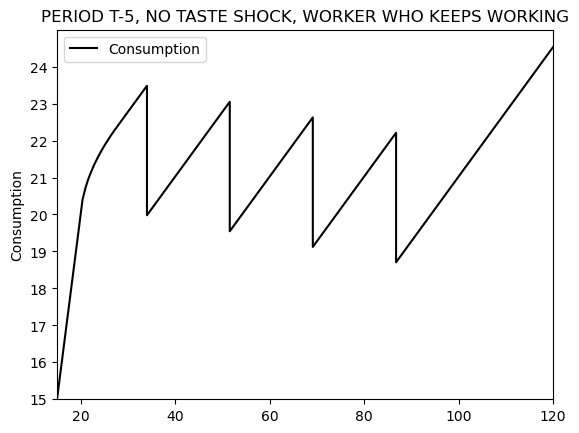

In [4]:
state_choice_dict = {
    "period": 37,  # Periods start at 0, the last period number T=44 has index 43 so period T-5 has index 38
    "lagged_choice": 0,  # choice in the previous period d_{t-1}, zero meaning working
    "choice": 0,  # choice in the current period d_t, zero meaning working
    "dummy_exog": 0,  # dummy exogenous state variable can be ignored for now
}

# get the index of the state choice pair in the endogenous grid
state_choice_index = get_state_choice_index_per_discrete_state_and_choice(
    model, state_choice_dict
)

# lets look at the value function and the policy function for the state choice pair on the endogenous grid i.e. the wealth grid
consumption_function = jnp.take(policy, state_choice_index, axis=0)
value_function = jnp.take(value, state_choice_index, axis=0)
wealth_grid = jnp.take(endog_grid, state_choice_index, axis=0)

# all three objects have the same shape, they are all 1D arrays
print(consumption_function.shape, value_function.shape, wealth_grid.shape)

# we can look at a table of the values e.g. using pandas
df = pd.DataFrame(
    {
        "Wealth": wealth_grid,
        "Consumption": consumption_function,
        "Value": value_function,
    }
)
print(df[:10])

# we can also plot these functions
plt.plot(wealth_grid, consumption_function, label="Consumption", color="black")
plt.xlim([15, 120])
plt.ylim([15, 25])
plt.yticks(np.arange(15, 25, 1))
plt.ylabel("Consumption")
plt.title("PERIOD T-5, NO TASTE SHOCK, WORKER WHO KEEPS WORKING")
plt.legend()
plt.show()

## Replicating Figure 4 (a) in Iskhakov et al. (2017)
We now have all tools necessary to replicate Figure 4 in Iskhakov et al. (2017). Figure (a) shows the policy functions for a worker who keeps working in Period T-5 for different model solutions with varying taste schock scale parameters $\lambda \in \{2 * 10^{-16}, 0.01, 0.05, 0.10, 0.15\}$

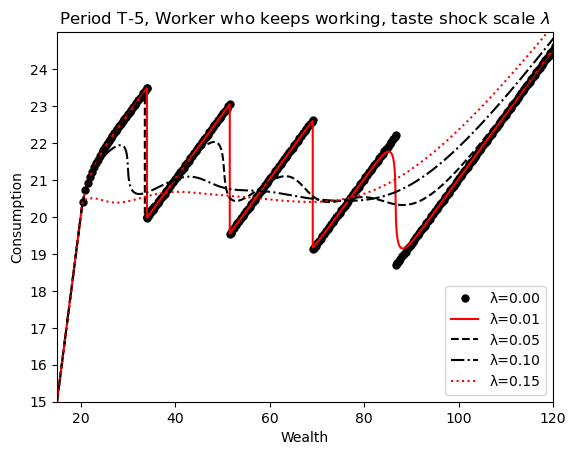

In [5]:
# set the style analogous to the Figure 4 in the paper
line_styles = [
    {
        "color": "black",
        "marker": "o",
        "linestyle": "None",
        "markersize": 5,
    },  # Black dots
    {"color": "red", "linestyle": "-"},  # Red solid line
    {"color": "black", "linestyle": "--"},  # Black dashed line
    {"color": "black", "linestyle": "-."},  # Black dash-dot line
    {"color": "red", "linestyle": ":"},  # Red dotted line
]

for k, taste_shock_scale in enumerate([2e-16, 0.01, 0.05, 0.10, 0.15]):
    params["lambda"] = taste_shock_scale
    state_choice_dict = {
        "period": 37,
        "lagged_choice": 0,
        "dummy_exog": 0,
        "choice": 0,
    }
    value, policy, endog_grid = solve_func(params)
    state_choice_index = get_state_choice_index_per_discrete_state_and_choice(
        model, state_choice_dict
    )
    wealth_grid = jnp.take(endog_grid, state_choice_index, axis=0)
    consumption_function = jnp.take(policy, state_choice_index, axis=0)
    value_function = jnp.take(value, state_choice_index, axis=0)
    plt.plot(
        wealth_grid,
        consumption_function,
        label=f"λ={taste_shock_scale:.2f}",
        **line_styles[k],
    )

plt.xlim([15, 120])
plt.ylim([15, 25])
plt.yticks(np.arange(15, 25, 1))
plt.ylabel("Consumption")
plt.title(r"Period T-5, Worker who keeps working, taste shock scale $\lambda$")
plt.xlabel("Wealth")
plt.legend()
plt.show()

We can also solve the slightly more complex model with income uncertainty as in Iskhakov et al. (2017) by setting `sigma`($\sigma$) and ` income_shock_mean` ($\mu$) in the `params` dictionary. More specifically the paper assumes $y_t=y \eta_t$, where $\eta_t$ is a $\log$-normally distributed multiplicative idiosyncratic income shock, $\log \eta_t \sim \mathcal{N}\left(\mu, \sigma^2\right)$

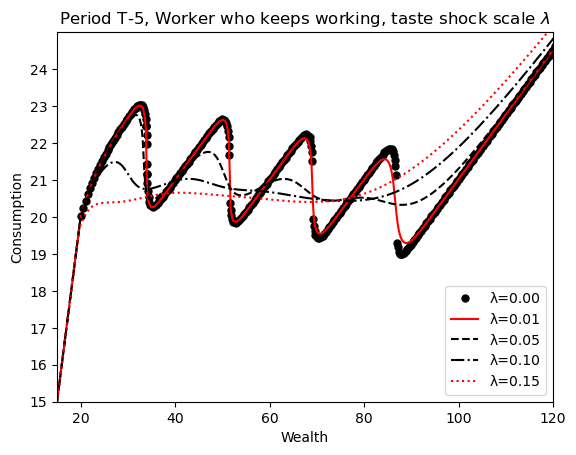

In [6]:
# set the income uncertainty parameters analogous to the Figure 4 (b) in the paper
params["sigma"] = np.sqrt(0.005)
params["income_shock_mean"] = -0.005 / 2

# set the style analogous to the Figure 4 in the paper
line_styles = [
    {
        "color": "black",
        "marker": "o",
        "linestyle": "None",
        "markersize": 5,
    },  # Black dots
    {"color": "red", "linestyle": "-"},  # Red solid line
    {"color": "black", "linestyle": "--"},  # Black dashed line
    {"color": "black", "linestyle": "-."},  # Black dash-dot line
    {"color": "red", "linestyle": ":"},  # Red dotted line
]

for k, taste_shock_scale in enumerate([2e-16, 0.01, 0.05, 0.10, 0.15]):
    params["lambda"] = taste_shock_scale
    state_choice_dict = {
        "period": 37,
        "lagged_choice": 0,
        "dummy_exog": 0,
        "choice": 0,
    }
    value, policy, endog_grid = solve_func(params)
    state_choice_index = get_state_choice_index_per_discrete_state_and_choice(
        model, state_choice_dict
    )
    wealth_grid = jnp.take(endog_grid, state_choice_index, axis=0)
    consumption_function = jnp.take(policy, state_choice_index, axis=0)
    value_function = jnp.take(value, state_choice_index, axis=0)
    plt.plot(
        wealth_grid,
        consumption_function,
        label=f"λ={taste_shock_scale:.2f}",
        **line_styles[k],
    )

plt.xlim([15, 120])
plt.ylim([15, 25])
plt.yticks(np.arange(15, 25, 1))
plt.ylabel("Consumption")
plt.title(r"Period T-5, Worker who keeps working, taste shock scale $\lambda$")
plt.xlabel("Wealth")
plt.legend()
plt.show()

## Interpolating the solution

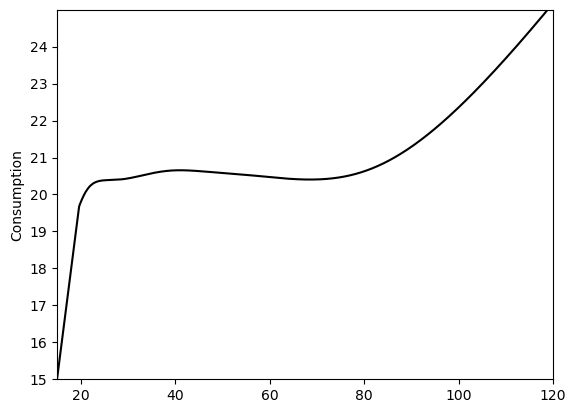

In [7]:
# policy_for_state_choice_vec returns the policy function for a given state and choice, after solving the model.
# value_for_state_choice_vec returns the value function for a given state and choice, after solving the model.

wealth_grid = np.linspace(0, 150, 1000)
# Compute consumption policy for the wealth grid
consumption = np.zeros_like(wealth_grid, dtype=float)
for var_id, wealth in enumerate(wealth_grid):
    policy_interp = policy_for_state_choice_vec(
        endog_grid_solved=endog_grid,
        policy_solved=policy,
        model=model,
        state_choice_vec=state_choice_dict,
        wealth=wealth,
    )
    consumption[var_id] = policy_interp

plt.plot(wealth_grid, consumption, label="Consumption", color="black")
plt.xlim([15, 120])
plt.ylim([15, 25])
plt.yticks(np.arange(15, 25, 1))
plt.ylabel("Consumption")
plt.show()

## Debugging the solution

Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Sparsity condition not provided. Assume all states are valid.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  3
Model setup complete.



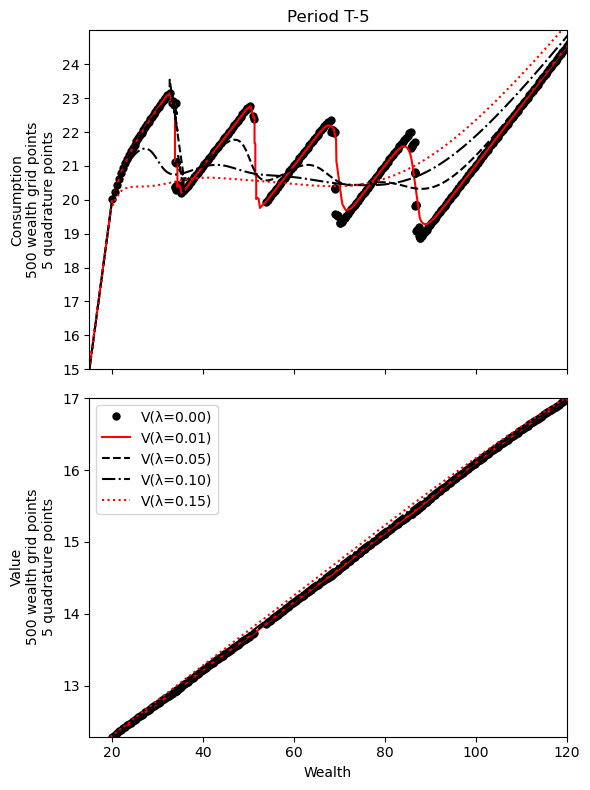

In [8]:
quadrature_points_list = [5]
wealth_grid_points_list = [500]
points_to_scan = [20]
taste_shock_scales = [2e-16, 0.01, 0.05, 0.10, 0.15]
n_periods = options["model_params"]["n_periods"]
test_periods = [
    n_periods - 6,
]  # zero-based index so T-5, T-2, T-1

fig, axes = plt.subplots(
    len(quadrature_points_list) * len(wealth_grid_points_list) * 2,
    len(test_periods),
    figsize=(
        len(test_periods) * 6,
        len(quadrature_points_list) * len(wealth_grid_points_list) * 2 * 4,
    ),
    sharex=True,
)

axes = axes.reshape(
    len(quadrature_points_list), len(wealth_grid_points_list), 2, len(test_periods)
)

for i, n_quadrature_points in enumerate(quadrature_points_list):
    for j, n_wealth_grid_points in enumerate(wealth_grid_points_list):
        options["model_params"]["quadrature_points_stochastic"] = n_quadrature_points
        options["state_space"]["continuous_states"]["wealth"] = jnp.linspace(
            0, 150, n_wealth_grid_points
        )
        options["tuning_params"] = {}
        options["tuning_params"]["fues_n_points_to_scan"] = points_to_scan[j]
        model = setup_model(
            options=options,
            state_space_functions=model_funcs["state_space_functions"],
            utility_functions=model_funcs["utility_functions"],
            utility_functions_final_period=model_funcs[
                "final_period_utility_functions"
            ],
            budget_constraint=model_funcs["budget_constraint"],
        )
        solve_func = get_solve_func_for_model(model)

        for t, test_period in enumerate(test_periods):
            for k, taste_shock_scale in enumerate(taste_shock_scales):
                params["lambda"] = taste_shock_scale
                state_choice_dict = {
                    "period": test_period,
                    "lagged_choice": 0,
                    "dummy_exog": 0,
                    "choice": 0,
                }
                value, policy, endog_grid = solve_func(params)
                state_choice_index = (
                    get_state_choice_index_per_discrete_state_and_choice(
                        model, state_choice_dict
                    )
                )
                wealth_grid = jnp.take(endog_grid, state_choice_index, axis=0)
                consumption_function = jnp.take(policy, state_choice_index, axis=0)
                value_function = jnp.take(value, state_choice_index, axis=0)

                # Consumption function subplot
                ax_c = axes[i, j, 0, t]
                ax_c.plot(
                    wealth_grid,
                    consumption_function,
                    label=f"λ={taste_shock_scale:.2f}",
                    **line_styles[k],
                )
                ax_c.set_xlim([15, 120])
                ax_c.set_yticks(np.arange(15, 25, 1))
                ax_c.set_ylim([15, 25])
                if k == 0:
                    ax_c.set_title(f"Period T-{n_periods - test_period - 1}")
                if t == 0:
                    ax_c.set_ylabel(
                        f"Consumption\n{n_wealth_grid_points} wealth grid points\n{n_quadrature_points} quadrature points"
                    )

                # Value function subplot
                ax_v = axes[i, j, 1, t]
                ax_v.plot(
                    wealth_grid,
                    value_function,
                    label=f"V(λ={taste_shock_scale:.2f})",
                    **line_styles[k],
                )
                ax_v.set_xlim([15, 120])
                y_min = value_function[wealth_grid >= 15].min()
                y_max = value_function[wealth_grid <= 120].max()
                ax_v.set_ylim([y_min, y_max])
                # ax_v.set_yticks(np.arange(0, 20, 1))
                if t == 0:
                    ax_v.set_ylabel(
                        f"Value\n{n_wealth_grid_points} wealth grid points\n{n_quadrature_points} quadrature points"
                    )

# Label the x-axis only on the bottom row
for t in range(len(test_periods)):
    axes[-1, -1, 1, t].set_xlabel("Wealth")
    axes[-1, -1, 1, t].legend()

plt.tight_layout()
plt.show()